# MNIST DATASET

Often known as "Hello Word" of Machine Learning

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

## Frame the Problem

It is a Supervised Learning Problem since you have given labels for each training examples. Moreover it is a multiclass classification problem.

 Finally, there is no continuous flow of data coming in
the system, there is no particular need to adjust to changing data rapidly, and the data
is small enough to fit in memory, so plain batch learning should do just fine.

## Select a Performance Measure


We will use Accuracy as a Performance measure

### Get the Data 
Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
                     
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
                                      
X,y = mnist["data"], mnist["target"]


## Take a Quick Look at the Data Structure

In [2]:
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

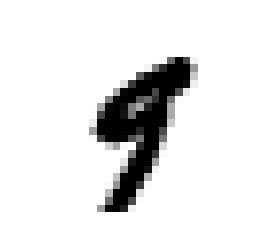

In [4]:
#Lets Peek One digit from the dataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

#Visulaise the image
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,
          interpolation = "nearest")

plt.axis("off")
plt.show()

In [5]:
#This image looks like 9.Lets checks this with the label.
y[36000]

9

Lets visualise few more dataset from the MNIST dataset

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    """
        Function to plot digit 
        img_per_row: no. of digit to be displayed in a row
        instance : Array of Digits to be displayed
    """
    size = 28
    images_per_row = min(len(instances), images_per_row)
    
    #Reshapng each instance
    images = [instance.reshape(size,size) for instance in instances]
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    
    n_empty = n_rows * images_per_row - len(instances)
    
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    
    plt.axis("off")

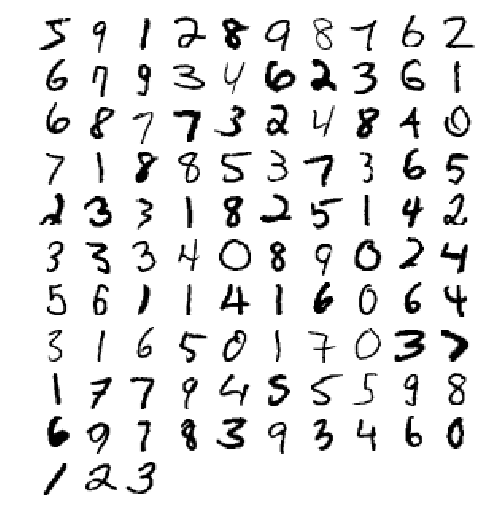

In [7]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:10000:600], X[10000:30600:600], X[30000:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.savefig("more_digits_plot")
plt.show()

## Crating a test datset
Wait! Before you look at the data any further, you need to create a test set, put it aside, and never look at it.

In [8]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [9]:
#Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar 
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index] 

##  Binary classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:


In [10]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
#Make Prediction
some_digit = X[10008]
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96735, 0.964  , 0.9646 ])

In [18]:
#Splitting using StraitifiedKFold and htraining model and finding its accuracy measures
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits = 3,random_state =42)

for train_index,test_index in skfold.split(X_train,y_train_5):
    
    clone_clf = clone(sgd_clf)
    
    X_train_fold = X_train[train_index]
    y_train_fold = (y_train_5[train_index])
    
    
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_fold,y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    
    #Find accuracy
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9277
0.96565
0.95485


Let create a Dumb Classifier that classifies every image is "not-5" class

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype = bool)

In [15]:
never_clf = Never5Classifier()

In [16]:
cross_val_score(never_clf,X_train,y_train_5,cv=3,scoring ="accuracy")

array([0.91065, 0.90985, 0.90845])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.

Lets use Confusion Matrix for performance measure

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[54004,   575],
       [ 1506,  3915]], dtype=int64)

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Lets calculate Precision and Recall

In [20]:

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8719376391982183

In [21]:
recall_score(y_train_5, y_train_pred)

0.7221914775871611

In [45]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7509842519685039

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

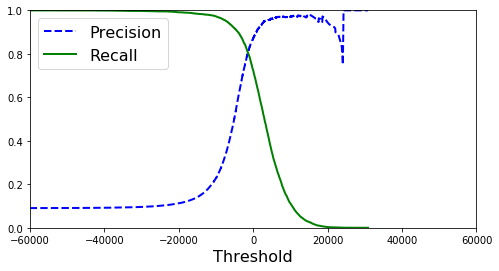

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0,1])
    plt.xlim([-60000,60000])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

If someone says “let’s reach 99% precision,” you should ask, “at
what recall?”


# The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate

The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.


In [26]:
#import 
from sklearn.metrics import roc_curve

#Calculate FPR,TPR,threshold
fpr , tpr, threshold = roc_curve(y_train_5,y_scores)

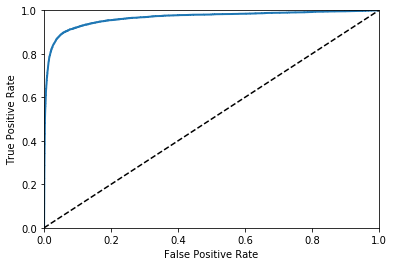

In [27]:
#Plot ROC Curve
def plot_roc_curve(fpr,tpr,label = None):
    plt.plot(fpr,tpr,linewidth = 2,label = label)
    plt.plot([0,1],[0,1],"k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plot_roc_curve(fpr,tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [28]:
#import
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9654805767367046

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright corner).

### Random Forest Classifier

In [31]:
#import 
from sklearn.ensemble import RandomForestClassifier

#Create a classifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probabs_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method = "predict_proba")


C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score

In [32]:
y_score_forest = y_probabs_forest[:,1]   #score = proba of positive class
fpr_forest,tpr_forest,threshold_forest = roc_curve(y_train_5,y_score_forest)

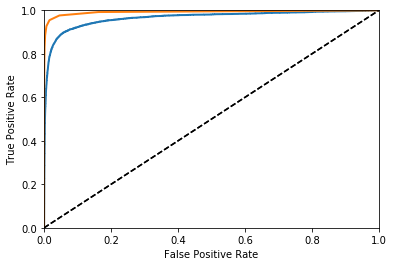

In [34]:
#Plot ROC curve
plot_roc_curve(fpr,tpr,label="SGD" )
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest" )
plt.show()

In [35]:
#Check AUC Score
roc_auc_score(y_train_5,y_score_forest)

0.9923501676610924

In [37]:
# Lets Find the Precision and Recall
y_train_pred = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
print("Precision Score:\t",precision_score(y_train_5,y_train_pred))
print("Recall Score:\t",recall_score(y_train_5,y_train_pred))

C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision Score:	 0.9829508196721312
Recall Score:	 0.8295517432208079


# Multiclass Classification


Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are vari‐
ous strategies that you can use to perform multiclass classification using multiple
binary classifiers.

### one-versus-all (OvA)
For example, one way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a
1-detector, a 2-detector, and so on). Then when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy
(also called one-versus-the-rest).


# one-versus-one (OvO) 
Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! 

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
class classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO). Let’s try this with the SGDClassifier:

In [38]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

 Under the hood,
Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.
To see that this is indeed the case, you can call the decision_function() method.
Instead of returning just one score per instance, it now returns 10 scores, one per
class:

In [39]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-19417.99644163, -82179.65456493,  -3444.69104056,
         -5844.64127293, -15788.26672368,   4965.52589337,
        -17663.65988099, -27857.33660943,  -5156.49218847,
         -6982.34749218]])

In [40]:
np.argmax(some_digit_scores)


5

In [41]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [43]:
sgd_clf.classes_[5]

5

When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In this case, the index of each
class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky.

## RandomForestClassifier

In [45]:
#Faster
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=int8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest
classifiers can directly classify instances into multiple classes. You can call
predict_proba() to get the list of probabilities that the classifier assigned to each
instance for each class:


In [48]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [49]:
#CrossValidation Scores
cross_val_score(forest_clf,X_train,y_train,cv=3,scoring = "accuracy")

array([0.94076185, 0.939997  , 0.94329149])

Improve the accuracy by Feature Scaling

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
#Calculate Cross validation score
cross_val_score(forest_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.94076185, 0.93989699, 0.94349152])

# KNearestNeighbor

In [54]:
#import
from sklearn.neighbors import NearestNeighbors
knn_clf = NearestNeighbors(n_neighbors=2)
knn_clf.fit(X_train,y_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=1.0)

In [55]:
knn_clf.predict([some_digit])

AttributeError: 'NearestNeighbors' object has no attribute 'predict'